Loading datasets...

Preparing characterization data...

Performing statistical analysis...

Statistical Analysis Results:
  Temperature       Test Used   p-value  Statistical Difference
0          22  Mann-Whitney U  0.043421                    True
1          FS  Mann-Whitney U  0.001471                    True
2          26          t-test  0.010714                    True
3          32          t-test  0.094038                   False

Performing bootstrap analysis...


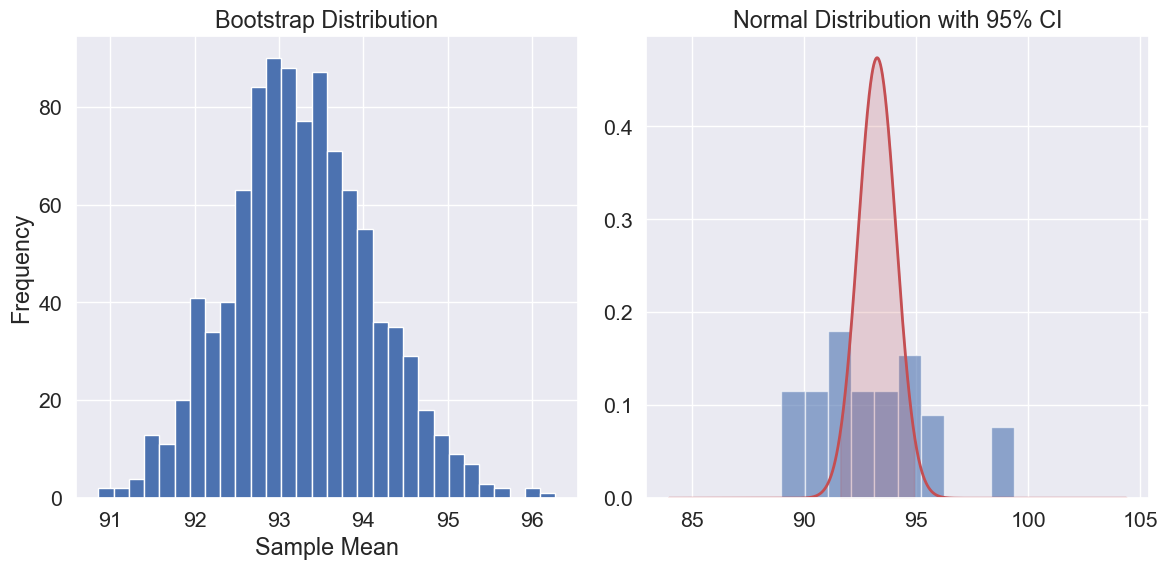


95% Confidence Interval: [91.62, 94.92]

Generating visualizations...


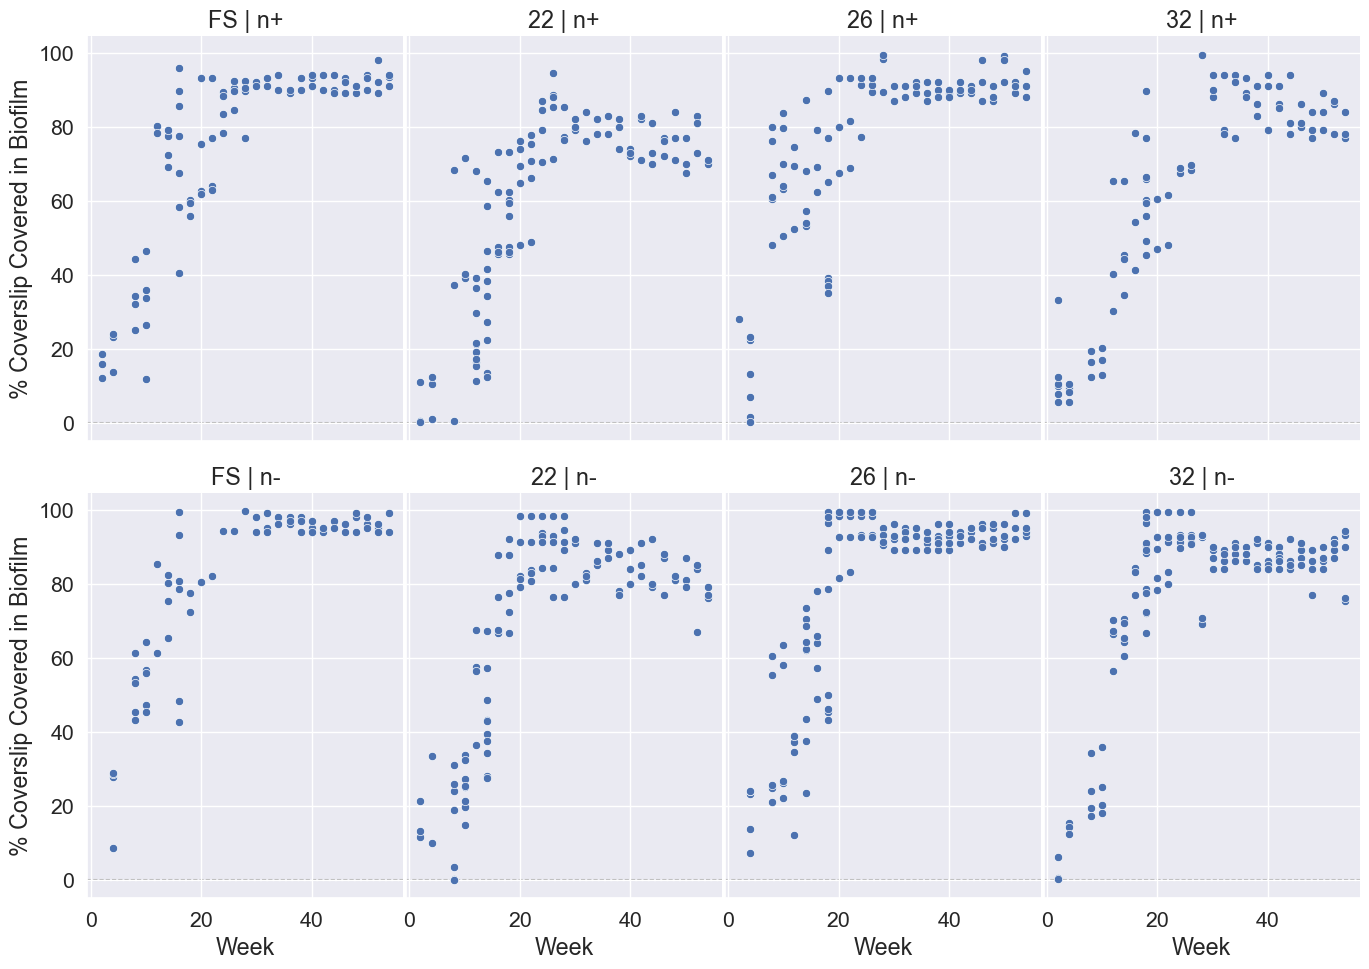

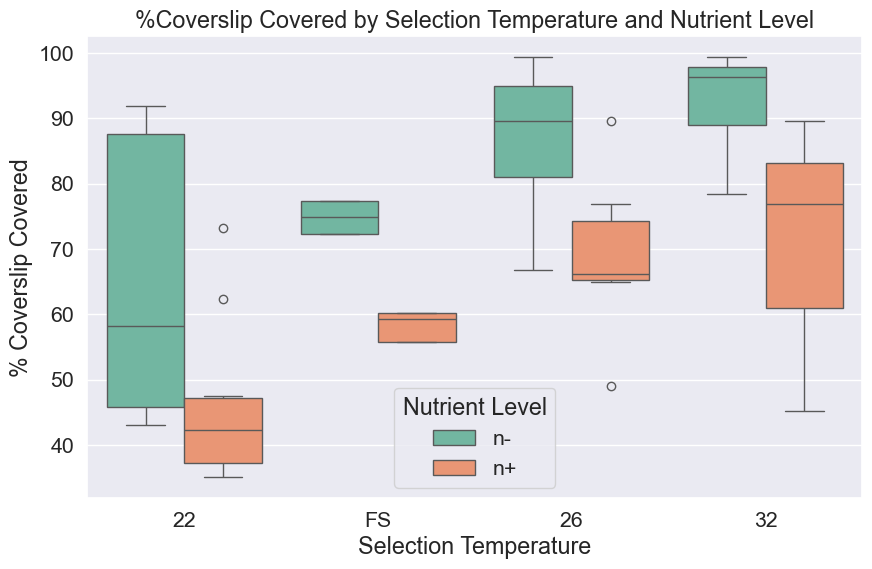

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

class ComprehensiveBiofilmAnalysis:
    def __init__(self):
        """Initialize analysis parameters"""
        np.set_printoptions(precision=3)
        sns.set(font_scale=1.4)
        
    def load_all_datasets(self):
        """Load all required datasets"""
        # Load characterization data
        self.df_char = pd.read_csv('20183009_biofilm_characterise.csv')
        self.df_char.columns = ['characteristic', 'selection_temp', 'bio_replicate', 
                              'nutrient', 'sampletype', 'traitvalue']
        
        # Load trajectory data
        self.trajectory_columns = ["cell_number", "average_cell_size", "pct_coverslip_covered", 
                                 "date", "selection_temperature", "nutrient_level", "week", 
                                 "biofilm_formation_rate", "evoplas", "assay_temperature"]
        self.df_traj = pd.read_csv('20180930_biofilm_trajectories.csv', 
                                  names=self.trajectory_columns, header=0)
        
        # Load formation ability data
        self.formation_columns = ["cell_number", "average_cell_size", "%coverslip_covered", 
                                "date", "selection_temperature", "nutrient_level", 
                                "biofilm_formation_rate", "evoplas", "assay_temperature"]
        self.df_form = pd.read_csv('20180930Ability_to_form_biofilms.csv')
        self.df_form.columns = self.formation_columns

    def prepare_characterization_data(self):
        """Process characterization data for analysis"""
        id_cols = ['sampletype', 'nutrient', 'selection_temp', 'bio_replicate']
        df2 = self.df_char.copy()
        df2 = df2.pivot(index=id_cols, columns='characteristic', values='traitvalue')
        df2.rename(columns={"size":"Size"}, inplace=True)
        return df2.reset_index()

    def growth_modeling(self):
        """Growth modeling functions"""
        def logifunc(x, A, x0, k):
            """Logistic function for biofilm growth"""
            return A / (1 + np.exp(-k * (x - x0)))
        return logifunc

    def fit_polynomials(self, x, y, deg_list=[1, 2, 4, 8, 16, 32]):
        """Fit polynomial models of different degrees"""
        mse_save = []
        for deg in deg_list:
            poly = np.polynomial.polynomial.Polynomial.fit(x, y, deg)
            y_fit = poly(x)
            mse = np.mean((y - y_fit)**2)
            mse_save.append(mse)
            
            plt.figure(figsize=(10, 6))
            plt.scatter(x, y, label='Data')
            plt.plot(x, y_fit, 'r-', label='Fit')
            plt.title(f'Degree = {deg} | MSE = {mse:.2f}')
            plt.legend()
            plt.show()
        return mse_save

    def perform_bootstrap_analysis(self, data, sample_size=10, n_samples=1000):
        """Perform bootstrap analysis"""
        sample_means = np.zeros(n_samples)
        for i in range(n_samples):
            sample = data.sample(n=sample_size, replace=True)
            sample_means[i] = sample.mean()
        return sample_means

    def plot_bootstrap_results(self, sample_means, original_data):
        """Plot bootstrap analysis results"""
        plt.figure(figsize=(12, 6))
        
        # Plot histogram of sample means
        plt.subplot(1, 2, 1)
        plt.hist(sample_means, bins=30)
        plt.title('Bootstrap Distribution')
        plt.xlabel('Sample Mean')
        plt.ylabel('Frequency')
        
        # Plot normal distribution with CI
        plt.subplot(1, 2, 2)
        x = np.linspace(original_data.min()-5, original_data.max()+5, 1000)
        tMean = sample_means.mean()
        tStd = sample_means.std()
        norm = stats.norm.pdf(x, loc=tMean, scale=tStd)
        
        plt.hist(original_data, density=True, alpha=0.6)
        plt.plot(x, norm, 'r-', lw=2)
        
        left_CI = stats.norm.ppf(0.025, loc=tMean, scale=tStd)
        right_CI = stats.norm.ppf(0.975, loc=tMean, scale=tStd)
        plt.fill_between(x, norm, where=(left_CI < x) & (x < right_CI),
                        color="r", alpha=0.2)
        
        plt.title('Normal Distribution with 95% CI')
        plt.tight_layout()
        plt.show()
        
        return left_CI, right_CI

    def statistical_analysis(self):
        """Perform comprehensive statistical analysis"""
        results = []
        for temp in self.df_form['selection_temperature'].unique():
            n_plus = self.df_form[(self.df_form['selection_temperature'] == temp) & 
                                 (self.df_form['nutrient_level'] == 'n+')]['%coverslip_covered']
            n_minus = self.df_form[(self.df_form['selection_temperature'] == temp) & 
                                  (self.df_form['nutrient_level'] == 'n-')]['%coverslip_covered']
            
            # Normality tests
            _, p_normal_plus = stats.shapiro(n_plus)
            _, p_normal_minus = stats.shapiro(n_minus)
            
            # Choose appropriate test
            if p_normal_plus > 0.05 and p_normal_minus > 0.05:
                t_stat, p_value = stats.ttest_ind(n_plus, n_minus, nan_policy='omit')
                test_used = "t-test"
            else:
                _, p_value = stats.mannwhitneyu(n_plus, n_minus, alternative='two-sided')
                test_used = "Mann-Whitney U"
                
            results.append({
                'Temperature': temp,
                'Test Used': test_used,
                'p-value': p_value,
                'Statistical Difference': p_value < 0.05
            })
        return pd.DataFrame(results)

    def create_visualizations(self):
        """Create all visualization plots"""
        # Biofilm coverage trends
        df3 = self.df_traj[self.df_traj.assay_temperature.isin(['22', '26', '32', 'FS'])]
        g = sns.relplot(data=df3, x='week', y='pct_coverslip_covered',
                       col='assay_temperature', row='nutrient_level', aspect=0.7)
        g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
        g.set_axis_labels("Week", "% Coverslip Covered in Biofilm")
        g.set_titles('{col_name} | {row_name}')
        g.tight_layout(w_pad=0)
        plt.show()
        
        # Boxplot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='selection_temperature', y='%coverslip_covered',
                   hue='nutrient_level', data=self.df_form, palette="Set2")
        plt.title('%Coverslip Covered by Selection Temperature and Nutrient Level')
        plt.ylabel('% Coverslip Covered')
        plt.xlabel('Selection Temperature')
        plt.legend(title='Nutrient Level')
        plt.show()

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("Loading datasets...")
        self.load_all_datasets()
        
        print("\nPreparing characterization data...")
        df_char_processed = self.prepare_characterization_data()
        
        print("\nPerforming statistical analysis...")
        stats_results = self.statistical_analysis()
        print("\nStatistical Analysis Results:")
        print(stats_results)
        
        print("\nPerforming bootstrap analysis...")
        subset = self.df_traj[self.df_traj.week.ge(26)]
        subset = subset[(subset.selection_temperature.eq('26')) & 
                       (subset.nutrient_level.eq('n-'))]
        coverslips = subset.pct_coverslip_covered
        sample_means = self.perform_bootstrap_analysis(coverslips)
        left_CI, right_CI = self.plot_bootstrap_results(sample_means, coverslips)
        print(f"\n95% Confidence Interval: [{left_CI:.2f}, {right_CI:.2f}]")
        
        print("\nGenerating visualizations...")
        self.create_visualizations()

if __name__ == "__main__":
    analyzer = ComprehensiveBiofilmAnalysis()
    analyzer.run_complete_analysis()